In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install category_encoders

     |████████████████████████████████| 80 kB 4.6 MB/s 


In [3]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import datetime


import numpy as np # recall that "np" etc. -- are abbreviated names we gave to these packages for notational convenience
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")


In [5]:
training_set_features = pd.read_csv("/content/drive/MyDrive/MMA869/Vaccine/Data/training_set_features.csv")
training_set_labels = pd.read_csv("/content/drive/MyDrive/MMA869/Vaccine/Data/training_set_labels.csv")
test_set_features = pd.read_csv("/content/drive/MyDrive/MMA869/Vaccine/Data/test_set_features.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/MMA869/Vaccine/Data/submission_format.csv")

# Target Encoding

In [6]:
import category_encoders as ce   # version 1.2.8
#from sklearn.preprocessing import LabelEncoder

In [7]:
#data = pd.concat([training_set_features, training_set_labels], axis=1) #df is for building the model

In [8]:
#data

In [9]:
# Target with default parameters
ce_target = ce.TargetEncoder(cols = ['employment_occupation', 'employment_industry', 'hhs_geo_region'])

ce_target.fit(training_set_features, training_set_labels['h1n1_vaccine'])
# Must pass the series for y in v1.2.8

training_set_features = ce_target.transform(training_set_features, training_set_labels['h1n1_vaccine'])
test_set_features = ce_target.transform(test_set_features)

In [10]:
training_set_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,0.230850,Non-MSA,0.0,0.0,0.207877,0.208909
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,0.258609,"MSA, Not Principle City",0.0,0.0,0.137898,0.133087
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,0.222437,"MSA, Not Principle City",2.0,0.0,0.141491,0.203600
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,0.210298,"MSA, Principle City",0.0,0.0,0.207877,0.208909
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,0.222437,"MSA, Not Principle City",1.0,0.0,0.245565,0.236220


## 1. Combine Train_Set_Features and Test_Set_Feature: to process the data,  Export and save the new dataset for backup

In [11]:
data = pd.concat([training_set_features.assign(ind="train"), test_set_features.assign(ind="test")]) # rows combined, train and test dataset to data

#test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")] split the train and test as original dataset

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53415 entries, 0 to 26707
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                53415 non-null  int64  
 1   h1n1_concern                 53238 non-null  float64
 2   h1n1_knowledge               53177 non-null  float64
 3   behavioral_antiviral_meds    53265 non-null  float64
 4   behavioral_avoidance         52994 non-null  float64
 5   behavioral_face_mask         53377 non-null  float64
 6   behavioral_wash_hands        53333 non-null  float64
 7   behavioral_large_gatherings  53256 non-null  float64
 8   behavioral_outside_home      53251 non-null  float64
 9   behavioral_touch_face        53159 non-null  float64
 10  doctor_recc_h1n1             49095 non-null  float64
 11  doctor_recc_seasonal         49095 non-null  float64
 12  chronic_med_condition        51512 non-null  float64
 13  child_under_6_mo

In [13]:
data.to_excel('data.xlsx')  #it will be saved in your python folder. manually delete the first row - row number 

## 2. Data Exploring

### 2.1 Missing Data:  **** Do imputation before FE as the blanks would cause trouble when we do FE ***

In [14]:
# import missingno as msno
# %matplotlib inline

In [15]:
# msno.matrix(data) # missing data

In [16]:
percent_missing = data.isnull().sum() * 100 / len(data)  # percentage of missing value
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

In [17]:
missing_value_df #percentage of the missing data

,column_name,percent_missing
respondent_id,respondent_id,0.000000
h1n1_concern,h1n1_concern,0.331368
h1n1_knowledge,h1n1_knowledge,0.445568
behavioral_antiviral_meds,behavioral_antiviral_meds,0.280820
behavioral_avoidance,behavioral_avoidance,0.788168
behavioral_face_mask,behavioral_face_mask,0.071141
behavioral_wash_hands,behavioral_wash_hands,0.153515
behavioral_large_gatherings,behavioral_large_gatherings,0.297669
behavioral_outside_home,behavioral_outside_home,0.307030
behavioral_touch_face,behavioral_touch_face,0.479266


In [18]:
pd.DataFrame(data).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

respondent_id                      0
h1n1_concern                     177
h1n1_knowledge                   238
behavioral_antiviral_meds        150
behavioral_avoidance             421
behavioral_face_mask              38
behavioral_wash_hands             82
behavioral_large_gatherings      159
behavioral_outside_home          164
behavioral_touch_face            256
doctor_recc_h1n1                4320
doctor_recc_seasonal            4320
chronic_med_condition           1903
child_under_6_months            1633
health_worker                   1593
health_insurance               24502
opinion_h1n1_vacc_effective      789
opinion_h1n1_risk                768
opinion_h1n1_sick_from_vacc      770
opinion_seas_vacc_effective      914
opinion_seas_risk               1013
opinion_seas_sick_from_vacc     1058
age_group                          0
education                       2814
race                               0
sex                                0
income_poverty                  8920
m

In [19]:
pd.Series({c: data[c].unique() for c in data}) # Unique numbers in each variables 

respondent_id                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
h1n1_concern                                           [1.0, 3.0, 2.0, 0.0, nan]
h1n1_knowledge                                              [0.0, 2.0, 1.0, nan]
behavioral_antiviral_meds                                        [0.0, 1.0, nan]
behavioral_avoidance                                             [0.0, 1.0, nan]
behavioral_face_mask                                             [0.0, 1.0, nan]
behavioral_wash_hands                                            [0.0, 1.0, nan]
behavioral_large_gatherings                                      [0.0, 1.0, nan]
behavioral_outside_home                                          [1.0, 0.0, nan]
behavioral_touch_face                                            [1.0, 0.0, nan]
doctor_recc_h1n1                                                 [0.0, nan, 1.0]
doctor_recc_seasonal                                             [0.0, nan, 1.0]
chronic_med_condition       

In [20]:
#data_original = pd.read_excel("C:\\MMA\\869\\Group\\data\\data.xlsx")

In [21]:
#data = data_original

In [22]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,ind
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,0.230850,Non-MSA,0.0,0.0,0.207877,0.208909,train
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,0.258609,"MSA, Not Principle City",0.0,0.0,0.137898,0.133087,train
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,0.222437,"MSA, Not Principle City",2.0,0.0,0.141491,0.203600,train
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,0.210298,"MSA, Principle City",0.0,0.0,0.207877,0.208909,train
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,0.222437,"MSA, Not Principle City",1.0,0.0,0.245565,0.236220,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,4.0,2.0,2.0,4.0,2.0,1.0,35 - 44 Years,NaN,White,Female,NaN,NaN,NaN,NaN,0.171403,"MSA, Principle City",1.0,1.0,0.207877,0.208909,test
26704,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,5.0,2.0,2.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Married,Rent,Employed,0.222437,Non-MSA,1.0,3.0,0.397893,0.189266,test
26705,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,1.0,4.0,3.0,1.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,0.222437,"MSA, Not Principle City",1.0,0.0,0.207877,0.208909,test
26706,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,2.0,3.0,4.0,4.0,3.0,2.0,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,0.258609,"MSA, Not Principle City",1.0,0.0,0.207877,0.208909,test


## 3. Feature Engineering

### 1) new created: best behavior

In [23]:
data['BestBehavior'] = data['behavioral_avoidance'] + data['behavioral_face_mask'] + data['behavioral_wash_hands']+ data['behavioral_large_gatherings'] + data['behavioral_outside_home']+ data['behavioral_touch_face']

In [24]:
data['careaboutseasonal'] = data['opinion_seas_vacc_effective'] + data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

### 2) replace the value with the numeric in Education

In [25]:
replace_values = {'< 12 Years' : 1, '12 Years' : 2, 'College Graduate' : 3 , 'Some College' : 4 ,  "Missing" : 5 }                                                                                          
data= data.replace({"education": replace_values})                                                         

In [26]:
# "Cleaning" the data -- part 1: converting data types that should be categorican into "category"


#data["BestBehavior"]=data["BestBehavior"].astype('category')
#data["h1n1_concern"]=data["h1n1_concern"].astype('category')
#data["h1n1_knowledge"]=data["h1n1_knowledge"].astype('category')
#data["behavioral_antiviral_meds"]=data["behavioral_antiviral_meds"].astype('category')
#data["behavioral_avoidance"]=data["behavioral_avoidance"].astype('category')
#data["behavioral_face_mask"]=data["behavioral_face_mask"].astype('category')
#data["behavioral_wash_hands"]=data["behavioral_wash_hands"].astype('category')
#data["behavioral_large_gatherings"]=data["behavioral_large_gatherings"].astype('category')
#data["behavioral_outside_home"]=data["behavioral_outside_home"].astype('category')
#data["behavioral_touch_face"]=data["behavioral_touch_face"].astype('category')
#data["doctor_recc_h1n1"]=data["doctor_recc_h1n1"].astype('category')
#data["doctor_recc_seasonal"]=data["doctor_recc_seasonal"].astype('category')
#data["chronic_med_condition"]=data["chronic_med_condition"].astype('category')
#data["child_under_6_months"]=data["child_under_6_months"].astype('category')
#data["health_worker"]=data["health_worker"].astype('category')
#data["health_insurance"]=data["health_insurance"].astype('category')
#data["opinion_h1n1_vacc_effective"]=data["opinion_h1n1_vacc_effective"].astype('category')
#data["opinion_h1n1_risk"]=data["opinion_h1n1_risk"].astype('category')
#data["opinion_h1n1_sick_from_vacc"]=data["opinion_h1n1_sick_from_vacc"].astype('category')
#data["opinion_seas_vacc_effective"]=data["opinion_seas_vacc_effective"].astype('category')
#data["opinion_seas_risk"]=data["opinion_seas_risk"].astype('category')
#data["opinion_seas_sick_from_vacc"]=data["opinion_seas_sick_from_vacc"].astype('category')
data["age_group"]=data["age_group"].astype('category')
data["education"]=data["education"].astype('category')
data["race"]=data["race"].astype('category')
data["sex"]=data["sex"].astype('category')
data["income_poverty"]=data["income_poverty"].astype('category')
data["marital_status"]=data["marital_status"].astype('category')
data["rent_or_own"]=data["rent_or_own"].astype('category')
data["employment_status"]=data["employment_status"].astype('category')
# data["hhs_geo_region"]=data["hhs_geo_region"].astype('category')
data["census_msa"]=data["census_msa"].astype('category')
#data["employment_industry"]=data["employment_industry"].astype('category')
#data["employment_occupation"]=data["employment_occupation"].astype('category')


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53415 entries, 0 to 26707
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   respondent_id                53415 non-null  int64   
 1   h1n1_concern                 53238 non-null  float64 
 2   h1n1_knowledge               53177 non-null  float64 
 3   behavioral_antiviral_meds    53265 non-null  float64 
 4   behavioral_avoidance         52994 non-null  float64 
 5   behavioral_face_mask         53377 non-null  float64 
 6   behavioral_wash_hands        53333 non-null  float64 
 7   behavioral_large_gatherings  53256 non-null  float64 
 8   behavioral_outside_home      53251 non-null  float64 
 9   behavioral_touch_face        53159 non-null  float64 
 10  doctor_recc_h1n1             49095 non-null  float64 
 11  doctor_recc_seasonal         49095 non-null  float64 
 12  chronic_med_condition        51512 non-null  float64 
 13  c

# Drop variables not related H1N1

In [28]:
#data = data.drop(['h1n1_concern','h1n1_knowledge', 'opinion_h1n1_sick_from_vacc'], axis = 1) 

#'doctor_recc_h1n1','opinion_h1n1_risk','opinion_h1n1_vacc_effective',

# Imputation missing data

In [29]:

# creating surrogates
for col in data:
    if data[col].isna().sum() != 0: 
        data[col + '_surrogate'] = data[col].isna().astype(int)

# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(data.select_dtypes(exclude=['int64','float64']))
data[data.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(data.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(data.select_dtypes(include=['int64','float64']))
data[data.select_dtypes(include=['int64','float64']).columns] = imputer.transform(data.select_dtypes(include=['int64','float64']))



In [30]:
data.to_csv("data_A.csv",sep = ',')

In [31]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,ind,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,1,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,0.230850,Non-MSA,0.0,0.0,0.207877,0.208909,train,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,2,White,Male,Below Poverty,Not Married,Rent,Employed,0.258609,"MSA, Not Principle City",0.0,0.0,0.137898,0.133087,train,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,3,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,0.222437,"MSA, Not Principle City",2.0,0.0,0.141491,0.203600,train,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,2,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,0.210298,"MSA, Principle City",0.0,0.0,0.207877,0.208909,train,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,4,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,0.222437,"MSA, Not Principle City",1.0,0.0,0.245565,0.236220,train,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,2.0,1.0,35 - 44 Years,missing_value,White,Female,missing_value,missing_value,missing_value,missing_value,0.171403,"MSA, Principle City",1.0,1.0,0.207877,0.208909,test,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

In [32]:
ind = data["ind"] #save the column having information from train feature table or from test feature table

In [33]:
data = data.drop(['ind'], axis = 1) 

# Create Dummy

In [34]:
# "Cleaning" the data -- wrapping up: creating dummy variables for non-numbers ("one hot encoding")
data = pd.get_dummies(data, columns = data.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)

pd.options.display.max_columns = None # remove the limit on the number of columns by default only 20 are shows

data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.230850,0.0,0.0,0.207877,0.208909,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.258609,0.0,0.0,0.137898,0.133087,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,0.222437,2.0,0.0,0.141491,0.203600,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,0.210298,0.0,0.0,0.207877,0.208909,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,0.222437,1.0,0.0,0.245565,0.236220,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,2.0,1.0,0.171403,1.0,1.0,0.207877,0.20

In [35]:
data['ind'] = ind  # add ind informaiton back to the data

In [36]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA,ind
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.230850,0.0,0.0,0.207877,0.208909,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,train
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.258609,0.0,0.0,0.137898,0.133087,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,train
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,0.222437,2.0,0.0,0.141491,0.203600,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,train
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,0.210298,0.0,0.0,0.207877,0.208909,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,train
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,0.222437,1.0,0.0,0.245565,0.236220,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,

# Scaling

In [37]:
# Normalizing continuous variables - standardlization approach
from sklearn.preprocessing import StandardScaler

In [38]:
scaling = StandardScaler()

In [39]:
data[['opinion_h1n1_vacc_effective','opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc','BestBehavior' ,'careaboutseasonal' ]] =scaling.fit_transform(data[['opinion_h1n1_vacc_effective','opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc','BestBehavior' ,'careaboutseasonal' ]])

In [40]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA,ind
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,-1.045526,2.0,-1.882737,-1.240387,-0.096883,0.230850,0.0,0.0,0.207877,0.208909,-0.648417,-1.531682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,train
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.149910,1.313000,4.0,-0.023220,-0.510912,1.414956,0.258609,0.0,0.0,0.137898,0.133087,0.648417,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,train
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.849713,-1.045526,1.0,-0.023220,-1.240387,-0.096883,0.222437,2.0,0.0,0.141491,0.203600,-1.296834,-0.741682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,train
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.849713,0.526825,5.0,0.906538,0.948037,-0.852803,0.210298,0.0,0.0,0.207877,0.208909,0.000000,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,train
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,0.526825,2.0,-0.952978,-1.240387,1.414956,0.222437,1.0,0.0,0.245565,0.236220,0.648417,-0.346682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Defining the vector of target (y) and matrix of features (X)

In [41]:
grouped = data.groupby(data.ind)
data_train = grouped.get_group("train") #original name： training_set_feature
data_test = grouped.get_group("test")  #original name: test_set_features

In [42]:
data_train = data_train.drop(['respondent_id','ind'], axis = 1)
data_test = data_test.drop(['respondent_id','ind'], axis = 1)

In [43]:
df = pd.concat([data_train, training_set_labels], axis=1) #df is for building the model

In [44]:
df = df.drop(['respondent_id'], axis = 1) # drop the 'respondent_id' from the lable dataset

In [45]:
df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,-1.045526,2.0,-1.882737,-1.240387,-0.096883,0.230850,0.0,0.0,0.207877,0.208909,-0.648417,-1.531682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.149910,1.313000,4.0,-0.023220,-0.510912,1.414956,0.258609,0.0,0.0,0.137898,0.133087,0.648417,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.849713,-1.045526,1.0,-0.023220,-1.240387,-0.096883,0.222437,2.0,0.0,0.141491,0.203600,-1.296834,-0.741682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.849713,0.526825,5.0,0.906538,0.948037,-0.852803,0.210298,0.0,0.0,0.207877,0.208909,0.000000,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,0.526825,2.0,-0.952978,-1.240387,1.414956,0.222437,1.0,0.0,0.245565,0.236220,0.648417,-0.346682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# Seasonal

In [46]:
df_seasonal = df.drop(['h1n1_vaccine'], axis = 1)

In [47]:
df_seasonal

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,-1.045526,2.0,-1.882737,-1.240387,-0.096883,0.230850,0.0,0.0,0.207877,0.208909,-0.648417,-1.531682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.149910,1.313000,4.0,-0.023220,-0.510912,1.414956,0.258609,0.0,0.0,0.137898,0.133087,0.648417,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.849713,-1.045526,1.0,-0.023220,-1.240387,-0.096883,0.222437,2.0,0.0,0.141491,0.203600,-1.296834,-0.741682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.849713,0.526825,5.0,0.906538,0.948037,-0.852803,0.210298,0.0,0.0,0.207877,0.208909,0.000000,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,0.526825,2.0,-0.952978,-1.240387,1.414956,0.222437,1.0,0.0,0.245565,0.236220,0.648417,-0.346682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [48]:
df_seasonal.to_csv('seasonal_balanced_data.csv')

In [49]:
data_test.to_csv('seasonal_test.csv')

In [ ]:
y = df_seasonal['seasonal_vaccine']
X = df_seasonal.drop(columns = 'seasonal_vaccine')

In [ ]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,hhs_geo_region,household_adults,household_children,employment_industry,employment_occupation,BestBehavior,careaboutseasonal,h1n1_concern_surrogate,h1n1_knowledge_surrogate,behavioral_antiviral_meds_surrogate,behavioral_avoidance_surrogate,behavioral_face_mask_surrogate,behavioral_wash_hands_surrogate,behavioral_large_gatherings_surrogate,behavioral_outside_home_surrogate,behavioral_touch_face_surrogate,doctor_recc_h1n1_surrogate,doctor_recc_seasonal_surrogate,chronic_med_condition_surrogate,child_under_6_months_surrogate,health_worker_surrogate,health_insurance_surrogate,opinion_h1n1_vacc_effective_surrogate,opinion_h1n1_risk_surrogate,opinion_h1n1_sick_from_vacc_surrogate,opinion_seas_vacc_effective_surrogate,opinion_seas_risk_surrogate,opinion_seas_sick_from_vacc_surrogate,education_surrogate,income_poverty_surrogate,marital_status_surrogate,rent_or_own_surrogate,employment_status_surrogate,household_adults_surrogate,household_children_surrogate,BestBehavior_surrogate,careaboutseasonal_surrogate,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_2.0,education_3.0,education_4.0,education_missing_value,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing_value,marital_status_Not Married,marital_status_missing_value,rent_or_own_Rent,rent_or_own_missing_value,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing_value,"census_msa_MSA, Principle City",census_msa_Non-MSA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,-1.045526,2.0,-1.882737,-1.240387,-0.096883,0.230850,0.0,0.0,0.207877,0.208909,-0.648417,-1.531682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.149910,1.313000,4.0,-0.023220,-0.510912,1.414956,0.258609,0.0,0.0,0.137898,0.133087,0.648417,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.849713,-1.045526,1.0,-0.023220,-1.240387,-0.096883,0.222437,2.0,0.0,0.141491,0.203600,-1.296834,-0.741682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.849713,0.526825,5.0,0.906538,0.948037,-0.852803,0.210298,0.0,0.0,0.207877,0.208909,0.000000,0.443319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.849713,0.526825,2.0,-0.952978,-1.240387,1.414956,0.222437,1.0,0.0,0.245565,0.236220,0.648417,-0.346682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Splitting X and y into training and testing

In [ ]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)

# split the data randomly into 80% train and 20% test samples 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21365, 82)
(5342, 82)
(21365,)
(5342,)


# Train a model on the training data, Use it to predict the values in the testing data, Compute the metrics of the model and compare models

In [ ]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

In [ ]:
class_threshold = 0.6073

# Model №1: Logistic regression

In [ ]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression()

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- lets see them
# Note, there is no easy way to show significance, etc. with sklearn
print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
top10positive = summary.head(10) # 10 largest (by value)
top10negative = summary.tail(10) # 10 smallest (by value)
top10list=pd.DataFrame()
top10list= top10list.append(pd.DataFrame(data = top10positive))
top10list= top10list.append(pd.DataFrame(data = top10negative))
top10list

Intercept: [-3.14337007]
Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: 


,Variable,Coefficient
155,employment_occupation_0.8445945945945946,1.55521
110,employment_industry_0.8445945945945946,1.55521
10,doctor_recc_seasonal,1.47724
60,age_group_65+ Years,1.45848
44,opinion_seas_risk_surrogate,0.748952
19,opinion_seas_risk,0.676391
59,age_group_55 - 64 Years,0.669861
14,health_insurance,0.648702
105,employment_industry_0.4596774193548387,0.636437
13,health_worker,0.604017


In [ ]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities

# Select the threshold value -- we will use Т=0.6073. Why? Why not 50%? Because 60.73% -- is the average probability of retention in our data (1451 "1"s out of 2389 datapoints) 
class_threshold = 0.6073

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

print(y_pred_prob[0:5]) # first 5 probabilities 
print(y_pred[0:5]) # resultant predicted classification 
print(y_test[0:5]) # actual outcomes

# oops ... for the first 5 customers our model made two mistakes: on 1st customer ("false positive") and on 3rd customer ("false negative")

[0.61909937 0.16537006 0.01926962 0.06366921 0.91871421]
[1 0 0 0 1]
23535    0
20286    0
4963     0
22182    0
25722    1
Name: seasonal_vaccine, dtype: int64


Metrics of the logistic regression model: 

Confusion matrix: 
[[2498  842]
 [ 357 1645]]
                                   Accuracy: 0.7755522276301011
                   SENSITIVITY (aka RECALL): 0.6614394853236831
                 SPECIFICITY (aka FALL-OUT): 0.8749562171628722
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8216783216783217
                 NEGATIVE PREDICTIVE VALUE): 0.7479041916167665


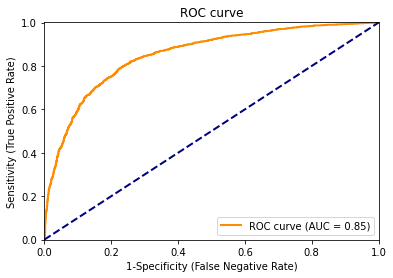

 AUC: 0.8525094061800874


In [ ]:
# Lets look at the model metrics 
print('Metrics of the logistic regression model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
# Apply variable selection with Stepwise Recursive Feature Selection 

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=20, step=1) # in this example we will select 20 variables; this number "20" is a hyperparameter to tune
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 20 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(30)

,0,1
50,employment_status_surrogate,1
59,age_group_55 - 64 Years,1
58,age_group_45 - 54 Years,1
66,race_Other or Multiple,1
67,race_White,1
106,employment_industry_0.46039035591274396,1
105,employment_industry_0.4596774193548387,1
45,opinion_seas_sick_from_vacc_surrogate,1
44,opinion_seas_risk_surrogate,1
110,employment_industry_0.8445945945945946,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[2487  894]
 [ 368 1593]]
                                   Accuracy: 0.7637588918008237
                   SENSITIVITY (aka RECALL): 0.6405307599517491
                 SPECIFICITY (aka FALL-OUT): 0.8711033274956217
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8123406425293218
                 NEGATIVE PREDICTIVE VALUE): 0.735581188997338


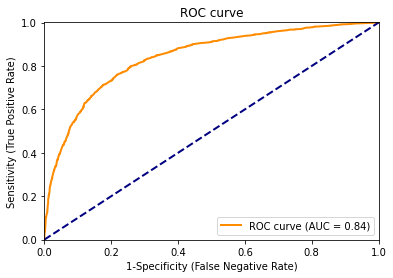

 AUC: 0.8415937304808119


In [ ]:
# Train the model and call it classifier_LR_RFE 
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection 
print('Metrics of the logistic regression model after variable selection: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
classifier_LR_RFE = rfe.fit(X, y)



NotADirectoryError: ignored

In [ ]:
prediction_seasonal= classifier_LR_RFE.predict_proba(data_test)[:,1] # probabilities
Prediction = pd.DataFrame(data={"Predicted Probability":prediction_seasonal}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_logistic.csv",sep = ',')

# Method №2: Random Forest

In [ ]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300) # recall what random_state mean

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

# A random forest model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble, 
# -- voting rules, 
# -- max number of leafs on each tree, 
# -- min number of datapoints at a leaf
# and so on

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=77300,
                       verbose=0, warm_start=False)

Metrics of the Random Forest model: 

Confusion matrix: 
[[2508  926]
 [ 347 1561]]
                                   Accuracy: 0.7616997379258704
                   SENSITIVITY (aka RECALL): 0.6276638520305589
                 SPECIFICITY (aka FALL-OUT): 0.8784588441330998
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8181341719077568
                 NEGATIVE PREDICTIVE VALUE): 0.7303436225975539


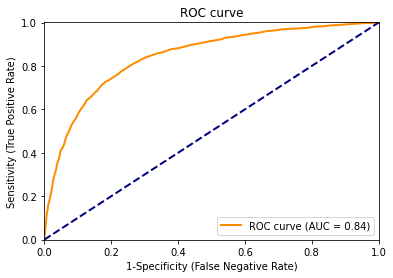

 AUC: 0.8440662020439736


In [ ]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'n_estimators': 600}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[2510  932]
 [ 345 1555]]
                                   Accuracy: 0.7609509546986147
                   SENSITIVITY (aka RECALL): 0.6252513067953357
                 SPECIFICITY (aka FALL-OUT): 0.8791593695271454
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8184210526315789
                 NEGATIVE PREDICTIVE VALUE): 0.7292271934921557


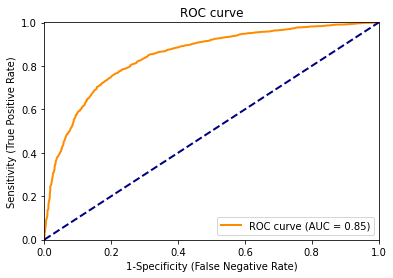

 AUC: 0.8475689698516348


In [ ]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] # as an example, we will tune the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities  
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))
    
# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

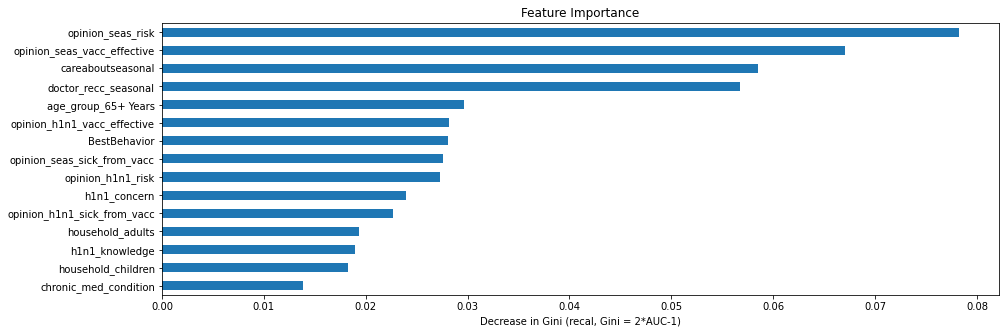

In [ ]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forect) there is no point to look at individual trees

# Useful intuition, however, can be obtained from the Feature Importance Plots

# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_ 

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

In [ ]:
#submission
grid_search_RF = grid_search.fit(X, y)
prediction_h1n1 = grid_search_RF.predict_proba(data_test)[:,1] # probabilities
Prediction = pd.DataFrame(data={"Predicted Probability":prediction_h1n1}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_rf.csv",sep = ',')


# Method №3: Gradient Boosting Machine

In [ ]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble, 
# -- speed of boosting ("learning rate", "decay rate"), 
# -- max number of leafs on each tree, 
# -- min number of datapoints at a leaf
# and so on

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=77300, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[2481  834]
 [ 374 1653]]
                                   Accuracy: 0.7738674653687757
                   SENSITIVITY (aka RECALL): 0.6646562123039808
                 SPECIFICITY (aka FALL-OUT): 0.8690017513134851
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8154908732116428
                 NEGATIVE PREDICTIVE VALUE): 0.7484162895927602


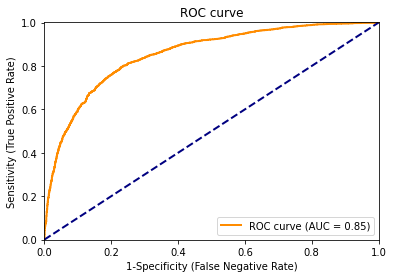

 AUC: 0.8546127428301423


In [ ]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'learning_rate': 0.1, 'n_estimators': 400}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[2467  796]
 [ 388 1691]]
                                   Accuracy: 0.77836016473231
                   SENSITIVITY (aka RECALL): 0.6799356654603941
                 SPECIFICITY (aka FALL-OUT): 0.8640980735551663
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8133718133718134
                 NEGATIVE PREDICTIVE VALUE): 0.7560527122280111


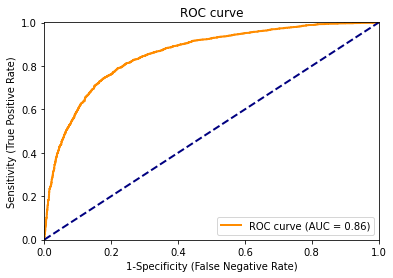

 AUC: 0.8569059283405054


In [ ]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.01, 0.1] # second, speed of boosting ("learning rate") and we will use two values 0.01 и 0.1

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data 
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
grid_search_GBM = grid_search.fit(X, y)

prediction_seasonal= grid_search_GBM.predict_proba(data_test)[:,1] # probabilities
Prediction = pd.DataFrame(data={"Predicted Probability":prediction_seasonal}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_GBM.csv",sep = ',')

# XGboost

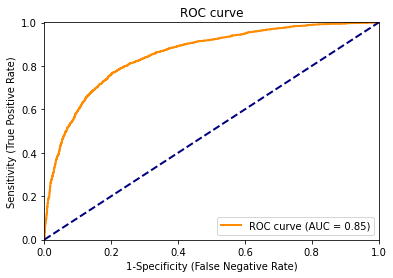

 AUC: 0.8540329151165748


In [ ]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(n_estimators=100, max_depth=3)
clf_xg.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = clf_xg.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'n_estimators': 300, 'learning_rate': 0.1}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[2472  813]
 [ 383 1674]]
                                   Accuracy: 0.7761138150505429
                   SENSITIVITY (aka RECALL): 0.6731001206272618
                 SPECIFICITY (aka FALL-OUT): 0.8658493870402802
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8138065143412737
                 NEGATIVE PREDICTIVE VALUE): 0.7525114155251141


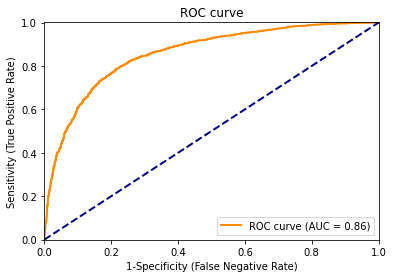

 AUC: 0.857462729133702


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.01, 0.1] # second, speed of boosting ("learning rate") and we will use two values 0.01 и 0.1

rand_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
rand_search = RandomizedSearchCV(estimator = clf_xg, cv = 5, param_distributions = rand_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
rand_search_XG = rand_search.fit(X_train, y_train)

# use the best model to predict the testing data 
y_pred_prob = rand_search_XG.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(rand_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
rand_search_XG = rand_search.fit(X_train, y_train)
prediction_h1n1 = rand_search_XG.predict_proba(data_test)[:,1] # probabilities
Prediction = pd.DataFrame(data={"Predicted Probability":prediction_h1n1}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_XG.csv",sep = ',')

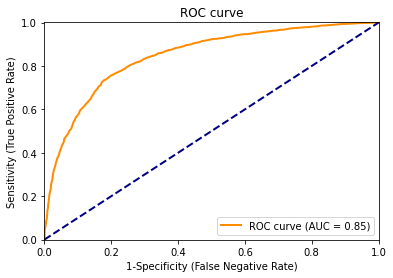

 AUC: 0.846890274259776


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada = AdaBoostClassifier(
    base_estimator=RandomForestClassifier(n_estimators=200), 
    n_estimators=100, random_state=0)
clf_ada.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = clf_ada.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'n_estimators': 300, 'learning_rate': 0.01}
Metrics of the Ada model with the optimized hyper-parameters": 

Confusion matrix: 
[[2506  944]
 [ 349 1543]]
                                   Accuracy: 0.7579558217895919
                   SENSITIVITY (aka RECALL): 0.6204262163248895
                 SPECIFICITY (aka FALL-OUT): 0.8777583187390543
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8155391120507399
                 NEGATIVE PREDICTIVE VALUE): 0.7263768115942029


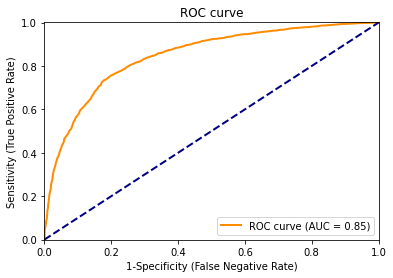

 AUC: 0.846890274259776


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.01, 0.1] # second, speed of boosting ("learning rate") and we will use two values 0.01 и 0.1

rand_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
rand_search = RandomizedSearchCV(estimator = clf_ada, cv = 5, param_distributions = rand_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
rand_search_ada = rand_search.fit(X_train, y_train)

# use the best model to predict the testing data 
y_pred_prob = rand_search_ada.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(rand_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Ada model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

rand_search_ada = rand_search.fit(X, y)
prediction_h1n1 = rand_search_ada.predict_proba(data_test)[:,1] # probabilities
Prediction = pd.DataFrame(data={"Predicted Probability":prediction_h1n1}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_ada.csv",sep = ',')

#stacking

>rf 0.780 (0.008)
>gbm 0.787 (0.007)
>xg1 0.787 (0.008)


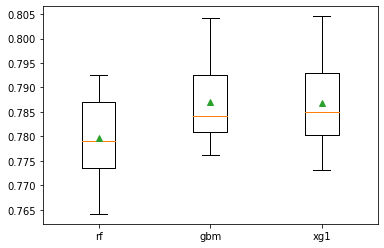

In [ ]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
	models = dict()
	models['rf'] = RandomForestClassifier(n_estimators=200)
	models['gbm'] = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)
	models['xg1'] = XGBClassifier(learning_rate=0.1, n_estimators=200)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# define the base models
level0 = list()
level0.append(('rf', RandomForestClassifier(n_estimators=200)))
level0.append(('gbm', GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)))
level0.append(('xg1', XGBClassifier(learning_rate=0.1, n_estimators=200)))

# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
yhat = model.predict_proba(data_test)[:,1]

Prediction = pd.DataFrame(data={"Predicted Probability":yhat}) 
Prediction.to_csv("/content/drive/MyDrive/MMA869/Vaccine/Predicted_seasonal_stacking_v2.csv",sep = ',')